In [ ]:
!pip install transformers
!pip install accelerate -U
!pip install datasets transformers[sentencepiece]
!pip install zstandard jsonlines
!pip install pymorphy2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torchtext import data
import torch.nn as nn
from google.colab import drive
import re
from string import punctuation
from tqdm import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import pymorphy2
from transformers import AutoTokenizer
import warnings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
meat = pd.read_csv('/content/drive/MyDrive/Inline/meatinfo.csv', sep=';')

In [ ]:
meat

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17888,"Ягнятина, шея, бк",Ягнятина
17889,Язык ягненка (н.зеландия) Отварные языки ягнят...,Ягнятина
17890,"Ягнятина, язык, зачищ. цена 100 руб.",Ягнятина
17891,"Як, задние части, 1 категория цена 550 руб.",Як


In [ ]:
filtered_df = meat.groupby('mtype').filter(lambda x: len(x)>=500)

In [ ]:
mtypes = filtered_df['mtype'].unique()
meat2idx = {t:i for i, t in enumerate(mtypes)}
idx2meat = {i:t for i, t in enumerate(mtypes)}

In [ ]:
filtered_df['itype'] = filtered_df['mtype'].replace(meat2idx)
filtered_df

,text,mtype,itype
0,12 частей баранина 12 частей баранина,Баранина,0
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина,0
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина,0
3,"Баранина, 12 частей, охл.",Баранина,0
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина,0
...,...,...,...
17816,"Цыпленок, четвертина, задняя",Цыпленок,5
17817,"Цыпленок, четвертина, задняя цена 100 руб.",Цыпленок,5
17818,ЦБ Шеи п/ф Свеженка ГОСТ зам пак Шеи куриные П...,Цыпленок,5
17819,"Цыпленок, шея, без кожи",Цыпленок,5


In [ ]:
def tokenize_ru(text, morph):
    text = text.replace(r"[^A-Za-zА-Яа-я]", " ")
    text = re.sub(r"[/\d!@#]", " ", text)
    tokens = word_tokenize(text)
    stop_words = stopwords.words('russian')
    stop_words.extend(['—', '–'])
    tokens = [i for i in tokens if (i not in punctuation) and (i not in stop_words)]

    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    tokens = [token for token in tokens if len(token) > 3]
    return tokens

In [ ]:
morph = pymorphy2.MorphAnalyzer()
text_tokens = [tokenize_ru(text, morph) for text in filtered_df['text']]
lebels = [i for i in filtered_df['itype']]

In [ ]:
max_sent_len = 0
for sent in text_tokens:
    max_sent_len = max(len(sent), max_sent_len)
max_sent_len

1049

In [ ]:
array = np.array(text_tokens)

# Находим длины подмассивов
lengths = np.array([len(subarray) for subarray in array])

# Находим среднюю длин
mean_length = np.mean(lengths)

# Находим медиану длин
median_length = np.median(lengths)

# Находим 95 персентиль
percentile = np.percentile(lengths, 95)
print("Средняя длина подмассивов:", mean_length)
print("Медианная длина подмассивов:", median_length)
print("95 персентиль массива:", percentile)

Средняя длина подмассивов: 11.61321328628787
Медианная длина подмассивов: 6.0
95 персентиль массива: 37.0


<ipython-input-12-6f3220d4eb91>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(text_tokens)


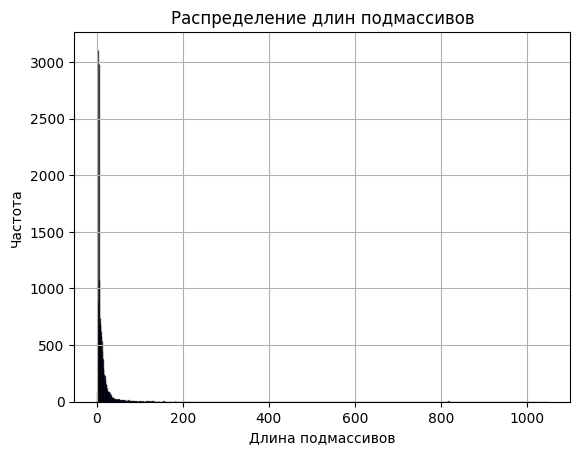

In [ ]:
plt.hist(lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Длина подмассивов')
plt.ylabel('Частота')
plt.title('Распределение длин подмассивов')
plt.grid(True)
plt.show()

In [ ]:
filtered_df['text_tokens']= text_tokens
filtered_df['lengths']=lengths

In [ ]:
filtered_df.head(10)

,text,mtype,itype,text_tokens,lengths
0,12 частей баранина 12 частей баранина,Баранина,0,"[часть, баранина, часть, баранина]",4
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина,0,"[баранина, часть, цена]",3
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина,0,"[баранина, часть, цена]",3
3,"Баранина, 12 частей, охл.",Баранина,0,"[баранина, часть]",2
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина,0,"[баранина, часть, цена]",3
5,"Баранина, 12 частей, охл. цена 230 руб.",Баранина,0,"[баранина, часть, цена]",3
6,"Баранина, 12 частей, охл. цена 270 руб.",Баранина,0,"[баранина, часть, цена]",3
7,"Баранина, 12 частей, охл. цена 280 руб.",Баранина,0,"[баранина, часть, цена]",3
8,"Баранина, 12 частей, охл. цена 285 руб.",Баранина,0,"[баранина, часть, цена]",3
9,"Баранина, 12 частей, охл. цена 310 руб.",Баранина,0,"[баранина, часть, цена]",3


In [ ]:
df = filtered_df[filtered_df['lengths']<=40]
df.shape

(15734, 5)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

(…)l_based_on_gpt2/resolve/main/config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

(…)ll_based_on_gpt2/resolve/main/vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

(…)ll_based_on_gpt2/resolve/main/merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

In [ ]:
def word2ind(sentence):
    try:
        res = []
        for word in sentence:
            inds = tokenizer.encode(word)
            for ind in inds:
                res.append(ind)
        return res
    except:
        return 0

In [ ]:
tokens = np.zeros([len(df['text_tokens']), 120], dtype=np.int32)
for i, sentence in enumerate(df['text_tokens']):
    inds = word2ind(sentence)
    for j, ind in enumerate(inds):
        tokens[i, j] = ind

In [ ]:
labels = [l for l in df['itype']]

In [ ]:
train_tokens, test_tokens, train_labels, test_labels = train_test_split(tokens, labels, test_size=0.2, random_state=32)

In [ ]:
train_data = [torch.tensor(sent, dtype=torch.int64) for sent in train_tokens]
train_target = [torch.tensor(l, dtype=torch.int64) for l in train_labels]
test_data = [torch.tensor(sent, dtype=torch.int64) for sent in test_tokens]
test_target = [torch.tensor(l, dtype=torch.int64) for l in test_labels]

In [ ]:
class MyDataSet(Dataset):
    def __init__(self, data, target):
        self.inputs = data
        self.labels = target
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, ind):
        inputs = self.inputs[ind]
        label = self.labels[ind]
        return {
            'input':inputs,
            'label':label
        }

In [ ]:
train_dataset = MyDataSet(train_data, train_target)
test_dataset = MyDataSet(test_data, test_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
num_epochs = 25
learning_rate = 0.001

VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 120
HIDDEN_DIM = 256
OUTPUT_DIM = 6
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = 0

In [ ]:
class GRU(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_rh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_rh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_rx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_rx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_zh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_zh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_zx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_zx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_nh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_nh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_nx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_nx = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden = None):

        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)

        for cur_idx in range(x.size(1)):
            r = torch.sigmoid(
                x[:, cur_idx] @ self.w_rx + self.b_rx + hidden @ self.w_rh + self.b_rh
            )
            z = torch.sigmoid(
                x[:, cur_idx] @ self.w_zx + self.b_zx + hidden @ self.w_zh + self.b_zh
            )
            n = torch.tanh(
                x[:, cur_idx] @ self.w_nx + self.b_nx + r * (hidden @ self.w_nh + self.b_nh)
            )
            hidden = (1 - z) * n + z * hidden

        return hidden

In [ ]:
class GRUModel(nn.Module):
    def __init__(self,vocab_size, embed_size, hidden_size, output_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = GRU(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = self.embed(x)
        hidden = self.gru(x)
        output = self.cls(hidden)
        return output

In [ ]:
model = GRUModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embed
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def training_freeze(model, criterion, optimizer, num_epochs, train_loader, test_loader, max_grad_norm=2, num_freeze_iter=1000):
    freeze_embeddings(model)
    for e in range(num_epochs):
        model.train()
        num_iter = 0
        for batch in tqdm(train_loader):
            if num_iter > num_freeze_iter and e < 1:
                freeze_embeddings(model, True)
            optimizer.zero_grad()
            input_embeds = batch["input"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1

        valid_loss = 0
        valid_acc = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in tqdm(test_loader):
                input_embeds = batch["input"].to(DEVICE)
                labels = batch["label"].to(DEVICE)
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                correct += (labels == prediction.argmax(-1)).float().sum()
                num_objs += len(labels)
                num_iter += 1

        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {correct/num_objs}")

In [ ]:
training_freeze(model, criterion, optimizer, num_epochs, train_loader, test_loader)

In [ ]:
def tokenize_ru(text, morph):
    text = text.replace(r"[^A-Za-zА-Яа-я]", " ")
    text = re.sub(r"[/\d!@#]", " ", text)
    tokens = word_tokenize(text)
    stop_words = stopwords.words('russian')
    stop_words.extend(['—', '–'])
    tokens = [i for i in tokens if (i not in punctuation) and (i not in stop_words)]

    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    tokens = [token for token in tokens if len(token) > 3]
    return tokens

def word2ind(sentence):
    try:
        res = []
        for word in sentence:
            inds = tokenizer.encode(word)
            for ind in inds:
                res.append(ind)
        return res
    except:
        return 0

def prep_text_to_classification(text, morph):
    tokens_text = tokenize_ru(text, morph)
    tokens = np.zeros([120], dtype=np.int32)
    ind_tokens = word2ind(tokens_text)
    for i, ind in enumerate(ind_tokens):
        tokens[i]=ind
    input_data = torch.tensor([tokens], dtype=torch.int64)
    return input_data

In [ ]:
obr = ['Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.',
       'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:',
       'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.']
morph = pymorphy2.MorphAnalyzer()
preds = []
model.eval()
with torch.no_grad():
    for i,text in enumerate(obr):
        input_data = prep_text_to_classification(text, morph).to(DEVICE)
        pred = model(input_data).argmax(-1)
        preds.append(pred)
        print(f'{i+1} образец это: {idx2meat[pred.item()]}')


1 образец это: Говядина
2 образец это: Кура
3 образец это: Говядина
